# Some Transects
Plotting a few transects from MOM6 PanAnt simulation - mainly to check how they look on the boundary.

**Need a better way of masking out topo in density field** \
Update - Density field plots fixed by Ashley with fix_zcoord function below
Generally, these look OK to me ...

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
db='panant.db'
session=cc.database.create_session(db)

In [3]:
client = Client(n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:38329 Dashboard: /proxy/38011/status,Cluster Workers: 6 Cores: 12 Memory: 34.36 GB


## Function for generating transects with proper z coordinate

In [18]:
layer_thickness = cc.querying.getvar('panan',"h",session,ncfile="%.ocean_thickness.nc")

def fix_zcoord(tracer_transect,layer_thickness):
    """
    This function takes a transect in the z direction of some quantity of interest as well as the
    layer thickness file, and returns the transect with a 'depth' coordinate. This z coordinate is
    the accumulative sum of layer thicknesses rather than the fixed 'zl' dimension
    
    Parameters:
        tracer_transect (xarray.DataArray) : Transect of some quantity of interest
        layer_thickness (xarray.DataArray) : Layer thickness for model run
        
    Returns:
        new_zcoord (xarray.DataArray) : Transect with 'depth' coordinate
        
    """
    
    # Retrieve time as well as x and y slices from the transect
    time = tracer_transect.coords["time"].values.reshape(1)[0]
    
    if len(tracer_transect.xh.dims) == 0:
        xslice = float(tracer_transect.xh.values)
    else:
        xslice = slice(tracer_transect.coords["xh"].values[0],tracer_transect.coords["xh"].values[-1])
    if len(tracer_transect.yh.dims) == 0:
        yslice = float(tracer_transect.yh.values)
    else:
        yslice = slice(tracer_transect.coords["yh"].values[0],tracer_transect.coords["yh"].values[-1])
    
    # Calculate accumulative sum of layer_thicknesses over appropriate transect
    accdepth = layer_thickness.sel(time=time,method="nearest").sel(xh=xslice,method="nearest").sel(yh=yslice).cumsum(dim="zl")
    
    print("Transect time:       ",time,"\nNearest Zcoord time: ", accdepth.coords["time"].values.reshape(1)[0])
    
    # Create a new dataarray with depth coordinate
    new_zcoord = xr.DataArray(
        data=tracer_transect.values,
        dims=["zl", "yh"],
        coords=dict(
            yh=(["yh"], tracer_transect.yh),
            depth=(["zl", "yh"], accdepth.values),
        ),
        attrs= tracer_transect.attrs
    )
    return new_zcoord


In [7]:

print("Time coordinate of our transect")
print(salt_transect.coords["time"].values , type(salt_transect.coords["time"].values))
print()
print("First Time Coordinate of 'Layer_thickness' .coords[time].values[0]")
print(layer_thickness.coords["time"].values[0],type(layer_thickness.coords["time"].values[0]))

# accdepth = layer_thickness.isel(time=0).sel(xh=0,method = "nearest").sel(yh=slice(-74,-60)).cumsum(dim="zl")
# # accdepth["time"] = layer_thickness.isel(time=0).sel(xh=0,method = "nearest").sel(yh=slice(-74,-60)).cumsum(dim="zl")

# s = slice(tracer_transect.coords["yh"].values[0],tracer_transect.coords["yh"].values[-1])
# x = tracer_transect.coords["xh"].values

Time coordinate of our transect
1992-01-03 12:00:00 <class 'numpy.ndarray'>

First Time Coordinate of 'Layer_thickness' .coords[time].values[0]
1992-01-16 12:00:00 <class 'cftime._cftime.DatetimeNoLeap'>


In [8]:
## We are able to select times from layer_thickness but not from salt_transect??
time = layer_thickness.coords["time"].values[3]
print(time,type(time))
layer_thickness.sel(time = time)

1992-04-16 00:00:00 <class 'cftime._cftime.DatetimeNoLeap'>


<xarray.DataArray 'h' (zl: 75, yh: 1690, xh: 7200)>
dask.array<getitem, shape=(75, 1690, 7200), dtype=float32, chunksize=(75, 1690, 7200), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 -81.1 -81.08 -81.06 -81.03 ... -37.16 -37.12 -37.08
  * zl       (zl) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.805e+03
    time     object 1992-04-16 00:00:00
Attributes:
    units:          m
    long_name:      Layer Thickness
    cell_methods:   area:mean zl:sum yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT

In [20]:
dodgytime = salt_transect.coords["time"].values
type(dodgytime.reshape(1)[0])

cftime._cftime.DatetimeNoLeap

In [ ]:
new_zcoord = xr.DataArray(
    data=tracer_transect.values,
    dims=["zl", "yh"],
    coords=dict(
        yh=(["yh"], tracer_transect.yh),
        depth=(["zl", "yh"], accdepth.values),
    ),
    attrs= tracer_transect.attrs
)

accdepth_values

In [9]:
rhopot2 = cc.querying.getvar(expt='panan', variable='rhopot2', session=session, frequency='5 daily',
                          chunks={'xh':100,'yh':120}).isel(time=-1)
u = cc.querying.getvar(expt='panan', variable='u', session=session, frequency='5 daily',
                          chunks={'xq':100,'yh':120}).isel(time=-1)
v = cc.querying.getvar(expt='panan', variable='v', session=session, frequency='5 daily',
                           chunks={'xh':100,'yq':120}).isel(time=-1)

In [10]:
xloc = -80
u_slice = u.sel(xq=xloc,method='nearest').load()
v_slice = v.sel(xh=xloc,method='nearest').load()
rhopot2_slice = rhopot2.sel(xh=xloc,method='nearest').load()
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])


Text(0.5, 1.0, 'zonal velocity')

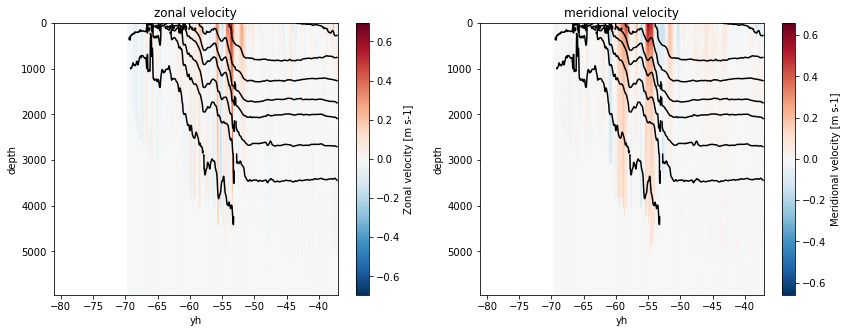

In [21]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
u_slice.plot(ax=ax[0])


v_slice.plot(ax=ax[1])

##
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[0],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])

##
# rhopot2_slice.plot.contour(ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[1].invert_yaxis()
ax[1].set_title('meridional velocity')
ax[0].invert_yaxis()
ax[0].set_title('zonal velocity')

In [12]:
xloc = 20
u_slice = u.sel(xq=xloc,method='nearest').load()
v_slice = v.sel(xh=xloc,method='nearest').load()
rhopot2_slice = rhopot2.sel(xh=xloc,method='nearest').load()
new_rhopot2_slice = fix_zcoord(rhopot2_slice,layer_thickness) 
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])


Transect time:        1992-10-28 12:00:00 
Nearest Zcoord time:  1992-10-16 12:00:00


Text(0.5, 1.0, 'meridional velocity')

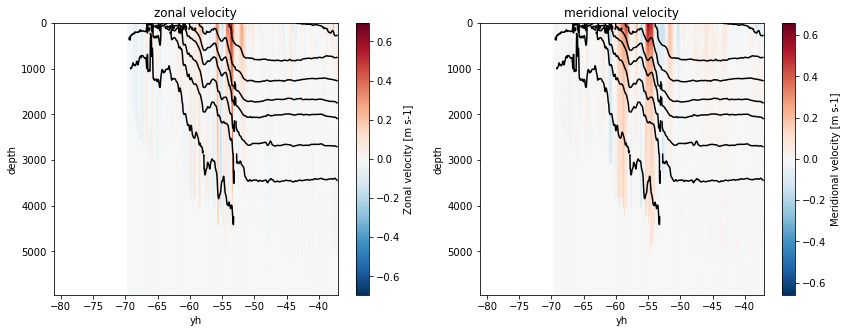

In [22]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
u_slice.plot(ax=ax[0])
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[0],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[0].invert_yaxis()
ax[0].set_title('zonal velocity')
v_slice.plot(ax=ax[1])
# rhopot2_slice.plot.contour(ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])

ax[1].invert_yaxis()
ax[1].set_title('meridional velocity')

In [14]:
xloc = 80
u_slice = u.sel(xq=xloc,method='nearest').load()
v_slice = v.sel(xh=xloc,method='nearest').load()
rhopot2_slice = rhopot2.sel(xh=xloc,method='nearest').load()

new_rhopot2_slice = fix_zcoord(rhopot2_slice,layer_thickness) 


Transect time:        1992-10-28 12:00:00 
Nearest Zcoord time:  1992-10-16 12:00:00


Text(0.5, 1.0, 'meridional velocity')

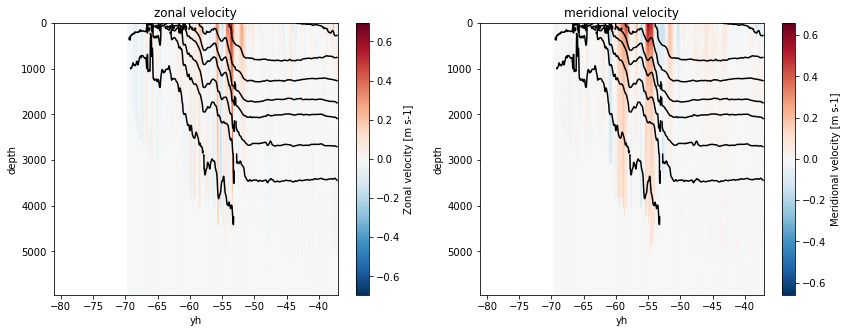

In [23]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
u_slice.plot(ax=ax[0])
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[0],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[0].invert_yaxis()
ax[0].set_title('zonal velocity')
v_slice.plot(ax=ax[1])
# rhopot2_slice.plot.contour(ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])


ax[1].invert_yaxis()
ax[1].set_title('meridional velocity')

In [16]:
xloc = -200
u_slice = u.sel(xq=xloc,method='nearest').load()
v_slice = v.sel(xh=xloc,method='nearest').load()
rhopot2_slice = rhopot2.sel(xh=xloc,method='nearest').load()
new_rhopot2_slice = fix_zcoord(rhopot2_slice,layer_thickness) 


Transect time:        1992-10-28 12:00:00 
Nearest Zcoord time:  1992-10-16 12:00:00


Text(0.5, 1.0, 'meridional velocity')

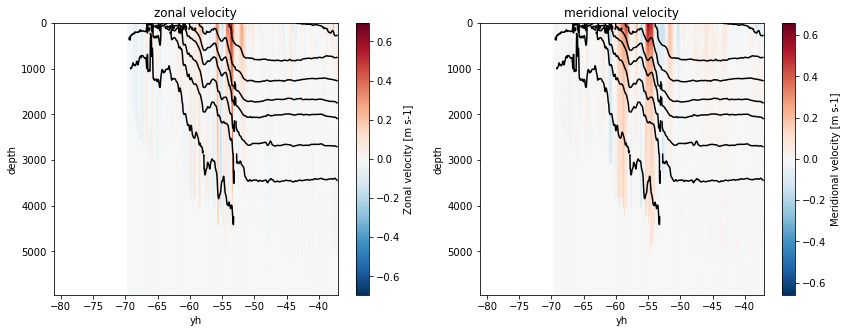

In [24]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
u_slice.plot(ax=ax[0])
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[0],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[0].invert_yaxis()
ax[0].set_title('zonal velocity')
v_slice.plot(ax=ax[1])
# rhopot2_slice.plot.contour(ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
new_rhopot2_slice.plot.contour(y = "depth",ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])

ax[1].invert_yaxis()
ax[1].set_title('meridional velocity')